Для выполнения тестового задания требуется разработать модель, которая будет способна различать заголовки реальных и выдуманных новостей.
Для обучения модели используйте данные из файла `train.tsv`. В файле находится таблица, состоящая из двух колонок. 
В колонке title записан заголовок новости. В колонке is_fake содержатся метки: 0 – новость реальная; 1 – новость выдуманная.
Для демонстрации работы модели используйте данные тестового набора из файла `test.tsv`. В нем также есть колонка title, данные которой являются входными для вашей модели.
Вам нужно скопировать файл `test.tsv`, переименовать его в `predictions.tsv` и заполнить колонку is_fake значениями предсказаний вашей модели, аналогично `train.tsv`. 
Изначально колонка заполнена значением 0.

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer  

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

In [ ]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, log_loss
from sklearn.metrics import roc_curve, roc_auc_score, auc
import xgboost as xgb
from xgboost import XGBClassifier

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving test.tsv to test (1).tsv
Saving train.tsv to train (1).tsv


In [ ]:
train_df = pd.read_csv('train.tsv', sep='\t')
train_df.head()

,title,is_fake
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1
1,Агент Кокорина назвал езду по встречке житейск...,0
2,Госдума рассмотрит возможность введения секрет...,1
3,ФАС заблокировала поставку скоростных трамваев...,0
4,Против Навального завели дело о недоносительст...,1


In [ ]:
test_df = pd.read_csv('test.tsv', sep='\t')
title_test = test_df['title']

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    5758 non-null   object
 1   is_fake  5758 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.1+ KB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    1000 non-null   object
 1   is_fake  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB


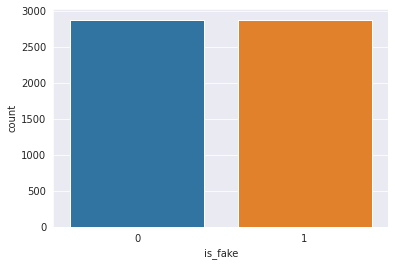

In [ ]:
ax = sns.countplot(x="is_fake", data=train_df)

### Baseline

В качестве бейзлайна построим модель логистической регрессии, построенную только на заданных текстовых заголовках, которые мы преобразуем в векторы на основе частоты каждого слова, встречающегося во всем тексте

In [ ]:
from sklearn.linear_model import LogisticRegression

sentences = train_df['title'].values
y = train_df['is_fake'].values

sentences_train, sentences_test, y_train, y_test = train_test_split(
    sentences, y, test_size=0.25, random_state=1000)

vectorizer = CountVectorizer()
vectorizer.fit(sentences_train)
X_train = vectorizer.transform(sentences_train)
X_test  = vectorizer.transform(sentences_test)

logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))

Accuracy: 0.8256944444444444
F1: 0.8108515448379804


In [ ]:
#  !pip install spacy==3.2.0

In [ ]:
import spacy

In [ ]:
!python -m spacy download ru_core_news_sm

     |████████████████████████████████| 16.4 MB 574 kB/s 
     |████████████████████████████████| 55 kB 2.2 MB/s 
     |████████████████████████████████| 8.2 MB 24.1 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')


In [ ]:
nlp = spacy.load("ru_core_news_sm")

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# препроцессинг текста
def preprocess_text(text):
    sw = stopwords.words('russian')
    text = text.lower()

    # удаляем emails
    text = re.sub('\S*@\S*\s?', '', text)
        
    # уберем кавычки
    text = re.sub("\'", "", text)
    
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') # удаляем пунктуацию
        
    text = ' '.join(text.split())
    
    # нормализация, удаление стоп слов и слишком коротких 
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if token.lemma_ not in sw
                                            and len(token.lemma_) > 2]
    
    text = ' '.join(tokens)
        
    return text

In [ ]:
def new_features(df):
    # Количество слов в названии
    df["num_words"] = df["title"].apply(lambda x: len(str(x).split()))
    
    # Количество уникальных слов
    df["num_unique_words"] = df["title"].apply(lambda x: len(set(str(x).split())))
    
    # Количество символов
    df["num_chars"] = df["title"].apply(lambda x: len(str(x)))
    
    # Количество стопслов
    df["num_stopwords"] = df["title"].apply(lambda x: len([w for w in str(x).lower().split() if w in stopwords.words('russian')]))
    
    # Количество знаков 
    df["num_punctuations"] = df["title"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
    
    # Количество слов, состоящих только из заглавных букв
    df["num_words_upper"] = df["title"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
    
    # Количество слов, начинающихся с заглавной буквы
    df["num_words_beg_upper"] = df["title"].apply(lambda x: len([w for w in str(x).split() if w[0].isupper()]))
    
    # Макс длина слова
    df["max_word_len"] = df["title"].apply(lambda x: np.max([len(w) for w in str(x).split()]))
    
    return df

In [ ]:
#количество наречий
def num_adv(docs, logging=False):
    lst = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print(" %d / %d" % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.pos_ == 'ADV']
        
        lst.append(len(tokens))
    return pd.Series(lst)

In [ ]:
# количество прилагательных
def num_adj(docs, logging=False):
    lst = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print(" %d / %d" % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.pos_ == 'ADJ']
        
        lst.append(len(tokens))
    return pd.Series(lst)

In [ ]:
#количество глаголов
def num_verb(docs, logging=False):
    lst = []
    counter = 1
    for doc in docs:
        if counter % 1000 == 0 and logging:
            print(" %d / %d" % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.pos_ == 'VERB']
        
        lst.append(len(tokens))
    return pd.Series(lst)

In [ ]:
train_df = new_features(train_df)
test_df = new_features(test_df)

In [ ]:
train_df.head()

,title,is_fake,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_beg_upper,max_word_len
0,Москвичу Владимиру Клутину пришёл счёт за вмеш...,1,10,10,77,2,0,0,3,13
1,Агент Кокорина назвал езду по встречке житейск...,0,8,8,57,1,0,0,2,9
2,Госдума рассмотрит возможность введения секрет...,1,8,8,75,0,0,0,2,11
3,ФАС заблокировала поставку скоростных трамваев...,0,7,7,57,1,0,1,2,13
4,Против Навального завели дело о недоносительст...,1,8,8,59,2,0,0,3,16


In [ ]:
train_df['title'] = train_df['title'].apply(lambda x: preprocess_text(x)) 
test_df['title'] = test_df['title'].apply(lambda x: preprocess_text(x)) 

In [ ]:
train_df["num_adv"] = num_adv(train_df['title'], logging=True)
test_df["num_adv"] = num_adv(test_df['title'], logging=False)

 1000 / 5758
 2000 / 5758
 3000 / 5758
 4000 / 5758
 5000 / 5758


In [ ]:
train_df["num_verb"] = num_verb(train_df['title'], logging=True)
test_df["num_verb"] = num_verb(test_df['title'], logging=False)

 1000 / 5758
 2000 / 5758
 3000 / 5758
 4000 / 5758
 5000 / 5758


In [ ]:
train_df["num_adj"] = num_adj(train_df['title'], logging=True)
test_df["num_adj"] = num_adj(test_df['title'], logging=False)

 1000 / 5758
 2000 / 5758
 3000 / 5758
 4000 / 5758
 5000 / 5758


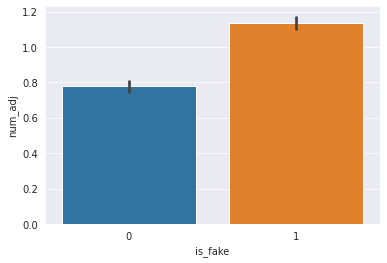

In [ ]:
ax = sns.barplot(x= train_df["is_fake"], y = train_df["num_adj"])

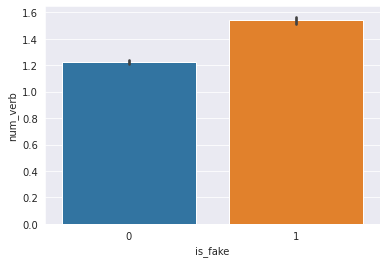

In [ ]:
ax = sns.barplot(x= train_df["is_fake"], y = train_df["num_verb"])

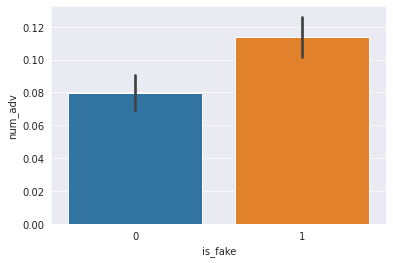

In [ ]:
ax = sns.barplot(x= train_df["is_fake"], y = train_df["num_adv"])

In [ ]:
# средние значения наших фичей для реальных/фейковых заголовков
train_df.groupby('is_fake').mean().T

is_fake,0,1
num_words,7.353595,10.093783
num_unique_words,7.330670,10.019104
num_chars,53.798541,76.454672
num_stopwords,1.169156,1.835707
num_punctuations,0.156999,0.555054
num_words_upper,0.279958,0.411949
num_words_beg_upper,2.133727,2.390413
max_word_len,11.077805,12.204238
num_adv,0.079889,0.113581
num_verb,1.222994,1.542202


Видно, что в фейковых заголовках количество слов,символов и знаков пунктуации больше, чем в реальных

## XGBClassifier

Построим модель только на наших фичах

In [ ]:
cvs = cross_val_score(XGBClassifier(random_state = 42, eval_metric='auc', silent=True),
                      train_df.drop(['title', 'is_fake'], axis=1), train_df['is_fake'],
                      scoring='f1')

In [ ]:
cvs.mean()

0.7494746833870548

Неплохое значение f1 без фичи title. Попробуем построить модель на тексте + наши новые фичи

In [ ]:
tfidf_vectorizer = TfidfVectorizer() 
train_text = tfidf_vectorizer.fit_transform(train_df["title"]) 

In [ ]:
features = tfidf_vectorizer.get_feature_names()
train_text = pd.DataFrame(train_text.toarray(), columns=features)
train_text.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,000,10,100,1000,100летию,100летнего,100летний,100тысячную,101,1012,...,ярцев,ясный,ястреб,яхта,яценюка,яшиным,ящик,ёлка,ёлки,ёршик
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
new_tr_df = train_df.drop(['title'], axis = 1)

new_tr_df = pd.concat([new_tr_df, train_text], axis=1)

In [ ]:
X = new_tr_df.drop('is_fake', axis = 1)
y = new_tr_df['is_fake']

In [ ]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify = y)

In [ ]:
def logistic_loss(clf, act, feat):
    return log_loss(act, clf.predict_proba(feat))

In [ ]:
xgb_clf = XGBClassifier(random_state = 42, eval_metric='auc')

xgb_clf.fit(X_train, y_train)

y_pred = xgb_clf.predict(X_test)

print('LogLoss', logistic_loss(xgb_clf, y_test, X_test))

LogLoss 0.4296359616613093


In [ ]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.88      0.76      0.82       837
           1       0.72      0.86      0.78       603

    accuracy                           0.80      1440
   macro avg       0.80      0.81      0.80      1440
weighted avg       0.82      0.80      0.80      1440



Немного улучшили результат бейзлайна

In [ ]:
#  !pip install shap

In [ ]:
import shap

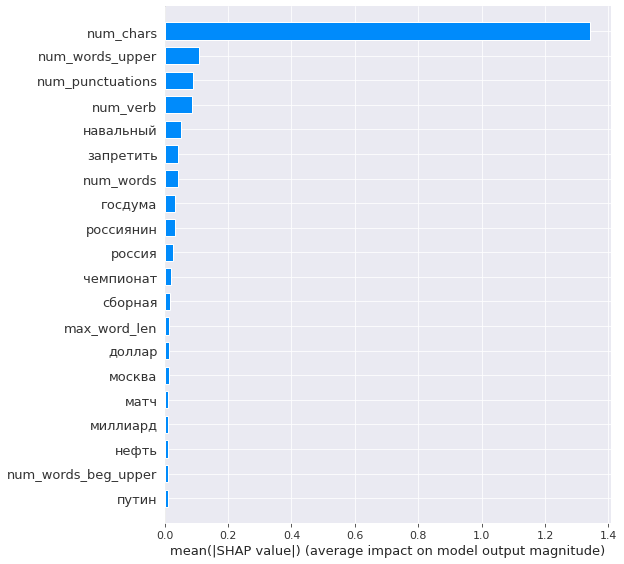

In [ ]:
# топ фичей
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

Количество символов в заголовке, количество слов, состоящих из заглавных букв и количество знаков пунктуации являются наиболее важными фичами

## CatBoostClassifier

Катбуст на тексте + фичи

In [ ]:
# !pip install catboost

In [ ]:
import catboost

In [ ]:
cvs = cross_val_score(catboost.CatBoostClassifier(text_features = ['title'], silent = True), 
                      train_df.drop('is_fake', axis=1), 
                      train_df['is_fake'].values, cv=3, scoring='f1')

In [ ]:
cvs.mean()

0.8757946847460828

Катбуст с tf-idf + фичи

In [ ]:
cvs = cross_val_score(catboost.CatBoostClassifier(silent=True), X, y, cv=3, scoring='f1')

In [ ]:
cvs.mean()

0.810760508232991

Видим, что лучше катбуст работает без tf-idf, построим такую модель

In [ ]:
X_train, X_test , y_train, y_test = train_test_split(train_df.drop('is_fake', axis = 1), 
                                                  train_df['is_fake'].values, test_size=0.25, 
                                                  random_state=42, stratify = y)

In [ ]:
clf_catboost = catboost.CatBoostClassifier(text_features = ['title'], random_state = 42, 
                                           eval_metric = 'TotalF1', silent = True)

clf_catboost.fit(X_train, y_train)

y_pred = clf_catboost.predict(X_test)

In [ ]:
print('LogLoss', logistic_loss(clf_catboost, y_test, X_test))


Logistic Loss:


0.2839038207519415

In [ ]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       731
           1       0.87      0.89      0.88       709

    accuracy                           0.88      1440
   macro avg       0.88      0.88      0.88      1440
weighted avg       0.88      0.88      0.88      1440



Пока катбуст дает наилучший результат для f1 = 0.88

In [ ]:
# !pip install git+https://github.com/huggingface/transformers
# !pip install -U nlp

In [ ]:
# !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
# !python pytorch-xla-env-setup.py --version 20200924  --apt-packages libomp5 libopenblas-dev

In [ ]:
# !pip install transformers

In [ ]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("sberbank-ai/ruRoberta-large")

Downloading:   0%|          | 0.00/674 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.73M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

In [ ]:
train_tensor = tokenizer(list(train_df["title"]), padding="max_length",
                        truncation=True, max_length=30,
                        return_tensors="pt")["input_ids"]

In [ ]:
class TitleData:
    def __init__(self, tensors, targ, ids):
        self.text = tensors[ids, :]
        self.targ = targ[ids].reset_index(drop=True)
    
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, idx):
        
        t = self.text[idx]
        y = self.targ[idx]
        
        return t, tensor(y)

In [ ]:
#  !pip install fastai==2.2.5

In [ ]:
import fastai
from fastai.text.all import *

In [ ]:
train_ids, valid_ids = RandomSplitter()(train_df)

target = train_df["is_fake"]

train_dl = DataLoader(TitleData(train_tensor, target, train_ids), bs=64)
valid_dl = DataLoader(TitleData(train_tensor, target, valid_ids), bs=512)
dls = DataLoaders(train_dl, valid_dl).to("cuda")

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler

In [ ]:
torch.cuda.is_available()

True

In [ ]:
bert = AutoModelForSequenceClassification.from_pretrained("DeepPavlov/rubert-base-cased-sentence", 
                                                          num_labels=2).train().to("cuda")

class BertClassifier(Module):
    def __init__(self, bert):
        self.bert = bert
    def forward(self, x):
        return self.bert(x).logits

model = BertClassifier(bert)

Downloading:   0%|          | 0.00/642 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/678M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at DeepPavlov/rubert-base-cased-sentence and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.25118863582611084)

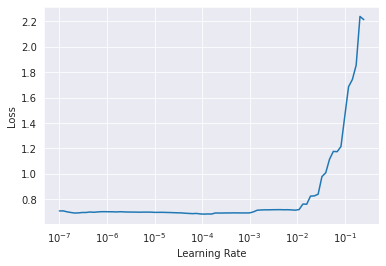

In [ ]:
learn = Learner(dls, model, metrics=[accuracy, F1Score()], loss_func=CrossEntropyLossFlat()).to_fp16()
learn.lr_find()

In [ ]:
learn.fit_one_cycle(3, lr_max=1e-5)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.636625,0.605235,0.663771,0.555683,02:40
1,0.570493,0.535083,0.734144,0.713483,02:41
2,0.519438,0.526450,0.748045,0.744268,02:40


Неплохой f1, но у катбуста все еще лучше

## Keras Sequential

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import os

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df['title'].values, train_df['is_fake'].values, test_size=0.25, random_state=1000)

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1 

In [ ]:
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [ ]:
embedding_dim = 50

model = Sequential()
model.add(layers.Embedding(input_dim=vocab_size, 
                           output_dim=embedding_dim, 
                           input_length=maxlen))
model.add(layers.GlobalMaxPool1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc', f1])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           489800    
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                510       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 490,321
Trainable params: 490,321
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, y_train,
                    epochs=50,
                    verbose=False,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy, f1_score = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
print("Training f1: {:.4f}".format(f1_score))
loss, accuracy, f1_score = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
print("Testing f1: {:.4f}".format(f1_score))

Training Accuracy: 1.0000
Training f1: 1.0000
Testing Accuracy:  0.8243
Testing f1: 0.8178


In [ ]:
def plot_history(history):
    acc = history.history['f1']
    val_acc = history.history['val_f1']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training f1')
    plt.plot(x, val_acc, 'r', label='Validation f1')
    plt.title('Training and validation f1')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

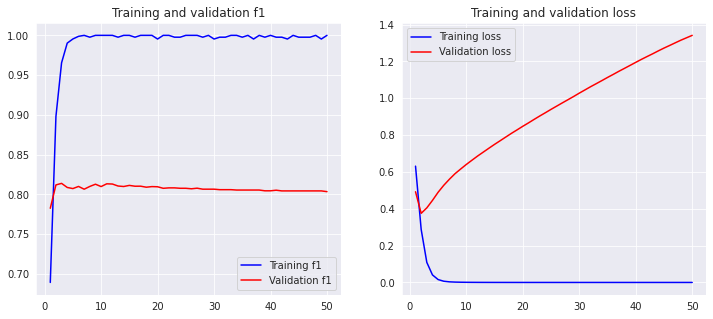

In [ ]:
plot_history(history)

## Predict

Итак, катбуст дал наилучший результат для f1, поэтому останавливаем свой выбор на этой модели, делаем предсказание и записываем результат в файл

In [ ]:
model = catboost.CatBoostClassifier(text_features = ['title'], random_state = 42, 
                                    eval_metric = 'TotalF1', silent = True)
model.fit(train_df.drop('is_fake', axis = 1), train_df['is_fake'].values)
pred = model.predict(test_df)

In [85]:
pd.DataFrame({"title":title_test,"is_fake":pred}).to_csv("predictions.tsv",sep="\t",index=False)

In [86]:
pd.read_csv("predictions.tsv",sep="\t").head()

,title,is_fake
0,роскомнадзор представить реестр сочетание цвет нежелательных россия,1
1,ночь минск президентский гора беларашмор пик демократия внезапно появиться лицо николай лукашенко,1
2,бывший спичрайтер юрий лозы рассказать трудность работа сергей шойгу,1
3,сельский церковь собрать рекордно низкий количество пожертвование сгореть тройной попадание молния,1
4,акция google рухнуть объявление перезапуск rutube,0


In [87]:
files.download('predictions.tsv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>